In [1]:
# a few packages we need to import
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 

NUMBER_STATES = 2
NUMBER_CONTROLS = 1

MAX_VELOCITY = 6.

DELTA_T = 0.1

## internal constants - DO NOT USE
_INTERNAL_DT = 0.01
_INTEGRATION_RATIO = 10
_GRAVITY = 9.81


def get_next_state(x,u):
    """
    This function integrates the pendulum for one step of DELTA_T seconds

    Inputs:
    x: state of the pendulum (theta,omega) as a 2D numpy array
    u: control as a scalar

    Output:
    the state of the pendulum as a 2D numpy array at the end of the integration
    """
    x_next = x[0]
    v_next = x[1]
    for i in range(_INTEGRATION_RATIO):
        xx_next = (x_next + _INTERNAL_DT * v_next)%(2*np.pi)
        v_next = np.clip(v_next + _INTERNAL_DT * (u-_GRAVITY*np.sin(x_next)-0.2*v_next), -MAX_VELOCITY, MAX_VELOCITY)
        x_next = xx_next
    return np.array([x_next,v_next])


def simulate(x0, policy, T):
    """
    This function simulates the pendulum for T seconds from initial state x0 using a policy (i.e. a function of x). It means that policy is called as policy(x) and returns one control)

    Inputs:
    x0: the initial conditions of the pendulum as a 2D array (angle and velocity)
    policy: a function that get a state as an input and return a scalar
    T: the time to integrate for

    Output:
    x (2D array) and u (1D array) containing the time evolution of states and control
    """
    horizon_length = int(T/DELTA_T)
    x=np.empty([2, horizon_length+1])
    x[:,0] = x0
    u=np.empty([horizon_length])
    t = np.zeros([horizon_length+1])
    for i in range(horizon_length):
        u[i] = policy(x[:,i])
        x[:,i+1] = get_next_state(x[:,i], u[i])
        t[i+1] = t[i] + DELTA_T
    return t, x, u


def animate_robot(x):
    """
    This function makes an animation showing the behavior of the pendulum
    takes as input the result of a simulation - dt is the sampling time (0.1s normally)
    """

    # here we check if we need to down-sample the data for display
    #downsampling (we want 100ms DT or higher)
    steps = 1
    use_dt = int(DELTA_T * 1000)
    plotx = x[:,::steps]

    fig = matplotlib.figure.Figure(figsize=[6,6])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-1.3,1.3], ylim=[-1.3,1.3])
    ax.grid()

    list_of_lines = []

    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'o', lw=2)
    list_of_lines.append(line)

    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])

        x_pend = np.sin(plotx[0,i])
        y_pend = -np.cos(plotx[0,i])

        list_of_lines[0].set_data([0., x_pend], [0., y_pend])
        list_of_lines[1].set_data([x_pend, x_pend], [y_pend, y_pend])

        return list_of_lines

    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [2]:
import math
class Invpendulum():
    def __init__(self):
        self.eps=7500
        self.timesteps=100
        self.gamma=0.1
        self.alpha=0.99
        self.epsilon=0.1
        self.discrete_theta=np.linspace(0, 2*np.pi, 50, endpoint=False)
        self.u_=np.array([-4,0,4])
        self.discrete_omega=np.linspace(-6, 6, 50)
        
        
    def get_cost(self,x,u):
        theta, omega = x
        g = (theta - math.pi)**2 + 0.01 * omega**2 + 0.0001 * u**2
        return g


    def get_policy_and_value_function(self,q_table):
        n_theta, n_omega, n_u = q_table.shape

        policy = np.zeros((n_theta, n_omega), dtype=int)
        value_function = np.zeros((n_theta, n_omega))
  
        for i in range(n_theta):
            for j in range(n_omega):
                qmin_index = np.argmin(q_table[i, j, :])
                policy[i, j],value_function[i, j] = self.u_[qmin_index],(q_table[i, j, qmin_index])

        return value_function,policy

    def q_learning(self,q_table):
        cost=[]

        for episode in range(self.eps):
            x = np.zeros((2,),dtype=int)
            x_old_theta=x[0]
            x_old_omega=x[1]
            xtheta_idx_min,xomega_idx_min=np.argmin(np.abs(self.discrete_theta-x_old_theta)),np.argmin(np.abs(self.discrete_omega-x_old_omega))
            c=0
            
            for t in range(self.timesteps):
            
                if np.random.uniform(0,1) < self.epsilon:
                    u = np.random.randint(0, 3)
                
                else:
                    u = np.argmin(q_table[xtheta_idx_min, xomega_idx_min])
      
                x_new = get_next_state(x,self.u_[u])
                x_new_theta=x_new[0]
                x_new_omega=x_new[1]

                idx_discrete_theta,idx_discrete_omega = np.argmin(np.abs(self.discrete_theta - x_new_theta)),np.argmin(np.abs(self.discrete_omega - x_new_omega))
                t= self.get_cost(x,self.u_[u]) + self.alpha*np.min(q_table[idx_discrete_theta, idx_discrete_omega,:]) - q_table[xtheta_idx_min, xomega_idx_min, u]
                q_table[xtheta_idx_min, xomega_idx_min, u] = q_table[xtheta_idx_min,xomega_idx_min , u] + self.gamma*t
                x = x_new
                xtheta_idx_min,xomega_idx_min=idx_discrete_theta,idx_discrete_omega 
                c+=self.get_cost(x,self.u_[u])
                
            cost.append(c)


        return q_table,cost
      
    def dummy_controller(self,x):
    
        theta_idx,omega_idx  = np.argmin(np.abs(self.discrete_theta - x[0])),np.argmin(np.abs(self.discrete_omega - x[1]))
        u_index = np.argmin(q_table[theta_idx,omega_idx,:])

        return self.u_[u_index]  

In [3]:
run=Invpendulum()
q_table=np.zeros((50,50,3))
q_t,cos=run.q_learning(q_table)
T = 10.
x0 = np.array([0,0.])
t, x, u = simulate(x0, run.dummy_controller, T)

In [4]:
animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACFxW1kYXQAAAKhBgX//53cRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU5IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAxOSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEyIGxvb2thaGVhZF90aHJlYWRz
PTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j
b21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0
PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu
dD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo
ZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9
NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADTRliIQAP//+92ifAptaQ3qA
5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACyBmSZ6XFJE4APMMeydN00/CqH
Qhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/lqmb6oagJo7SFBr1OBuUCQQFG
2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2VvBtnz7czyXRN90c1rKBwG6h7+
y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcKL8eOssBoMcX7PXzJUsrbPviI
bDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFVtil7hBi79CSaTb0xDWuZN3nD
q23yvHA3INZjOgNcsA87FgS7RxahBxc+OmniIFYF+j3coOCrpdCKPg6PUsYPPJIyvfy6GBthd1X3
VUGikZO58pJ6STZmQo61urgqv/Mz2++KiAC5sx/LX9hIP+Jz5nrKxbXWaoRrDbx+QTTsuhUA2e33
z9YU6HaQ/iopLYQ5bZH9oDdnsb55tYCanIZrBIo4/vjG7G8VvmrUeUbwMfc7oEWDcg2+4c5v0sc6
J3GG3IncK0XM0MpnrGfqYO8ABZaLpfl07/Azf72gfzhGdnJe9UFlPHPftj0JYFmzxJbGZ4tq5W0I
MJZcaZ+qytfjqtBYwHi72Vi4Q+zbN0Watz3Sk6J470wKzk88jdQAAAMAQegBriHGn49WnwX32oPY
nQnn+kOKKLl8Y3SWZjTHvV4jC2q9W3Nkzk5YRBcLMkxJDzCQAz0gWQqDMa7xhD52L7CKKG3xm8bh
13y5Hv2oTUWp8CTml8VSdoHrM7pTCNIEMpNQzWUyatQUz06hWOkgt971uPjOzmnqaYl5aiXI/pMg
E+ajlf8mz05SKnolBbcTg1JxgDJOFsSrlFqt/zmg5VvX1lfOHathcvpy7ed/vYUqjLvlvYNQWFbX
VqwvSB187D1x3r/8vNSgrBvt+euGnfyL6MMiPMtsB8IKiSnnrR7oYrWc9p6Ly4KNL7ZynNp9LGfm
QZvPW/9e6S2omsxVxPmRkdZuDGfDGU5FoQf9T1cYLTVJN6LG/Y2SOrpwl+3HxGi2FpzVcAVeYmQ2
DoEExDuljPzIRKLJf3v4hHlq819cMVWVngPJOe2W1yYpWtSJHEBxbf2OAqV/l/hEC0GIRNPoR2wF
6h3Hp6qa2U/2auyKpLkDaA9SmxIgNaYdhKOJknWTWXdYOwrYXVQ5gJsbj57gbWfNHq3N4ZTJkg2K
oktxmEXjEH/9+07n+YmMtjWF3+Q0jy5S8V9ApimsC/sl+5vhYJxBsknrIfSNLJs2U8ISUv8+2M2S
VgowPM5K3JySjgAI9ul4SqGyX1g64LeQovtjhq+9snRjzY4FwLZZim/GPzF+uRkbMN+TfWfikR70
AUe5Ah47bQlvw4A4v8LxskMAg/nInNraEFsSFKEpms3ccJeG+Ah0wqblc/Pe2FBkiNq6XILr0enq
gjqAc0IQLDDSJin/uin531UOP2M5AqtgFG5LdohGAExNL03PMGtKLCtdEyxt7imiadYR52Mvva+F
UPhggSstautCwKea66naDBbVUCwru2PrN+4uENObnB0B2BNvThjQIS6f4NlHE3cwW7fmI/YLukmN
8dMpNeoHeQIl+eXzTxixfgPZuf2xqAmJulUBnTGvD40vkuiz0yHi2Br2eM0F3uc3cExxANbC+NV0
CsI2+/N3nE3pOaMJRRwnT//DcE2VVm8dFW2++QeZmkZ6NiSoHQ2pvV7NAfsoZwGGJpZ2QLydL/Me
z535Q5Sfamt2a43rBOO8reeuoILY16xDPCBFjgu0e8P+5vdbZvOs4LlOs1cAV1j3lGw563mq0YZH
d1Z6zICVfe0ohs2/GEIpqxHln1F3Z80ZchkFA69QvkTEf9PJN8ReiyQLLvcbr8WWB7eGOaKYYe1W
7uPS0NqSo0w0rY0FR9xIWa0ici0naJejLpksde+IfFVB1hgqQNM1R5brw02nLlYpB9GbG3lVb14Q
YSrDZ8xzpZMPoAofOxJ6QQOdk6ZMilvnK7tWC2ax5xQUbf6exsDdf/jxHGTwrHhxcn3ROjEcvBuY
4pjqjcNSthmxBdGY6mggX6fe86gOoHCjnK9+l+A1wAgS9iDmWm3lHbTEOxfd2EUcLOBNyywuec9g
GSuSoJ8qv8tJRiKBvx//6EMuSViECv2x8hDRH9jV7wmvmAdS7SZ9iGBSzhL7jRcc7xySMvhMiebF
auDtxLGZ/y10iUepxVKEv7RLkkxhIH6Kwg3hfasvUMVxL7FzM8bMKqoMhsq8cVtsc27qIXrjabo7
5tkqBUDSMAeQsJqkDXT8cNwjTCu2U95IgCcBGh7UYMjYOAAAa6BDM0XvVrGzD5Dli90CEZkqrks4
AGrh3QGiiYFHeAAX3HhbemR6w1QJDg4M8F9KlDywNpWx9qI19TzngGLSBGrSoQYTlduVXJ5SoxfT
4VfsmPxnmW7/BPG0vaMq/6T1LFt17oXt2Td104V9Z7mKVCB6meS9S90ajlOalntdrgeyyeHuRdun
iBhK3xfbHQJj7hWUsI4cJP8bk2nzTqKBXlAzF2neNbwkAzTI2y/dFLcEGCYyOe5W0w07byjGDnub
diWy+3k5ezocFFUoUelA+h7vjvJNKruNa05CuvjOsHqUGqnqlUPx/vxdzWW1+pRN/yEW6dxS2Gwv
c5STYmqZ3chJMK5GMJjn8cUGgM4fePKLJz/40pgDUHt7OfAzV5W8HB06tH6neFdwDuE/pSIoL7qm
kjLc5O1rPkjAduf+Map3d5nCKIURyL6tS0nWrppchXAh7ECjbGMi6rTxe8yA0CD3yErplxAUbXRz
oaCfsKmLn3jzFbtlxJLLK

Text(0.5, 0, 'Time [s]')

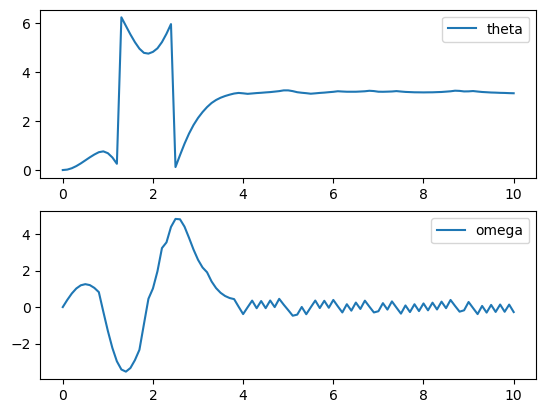

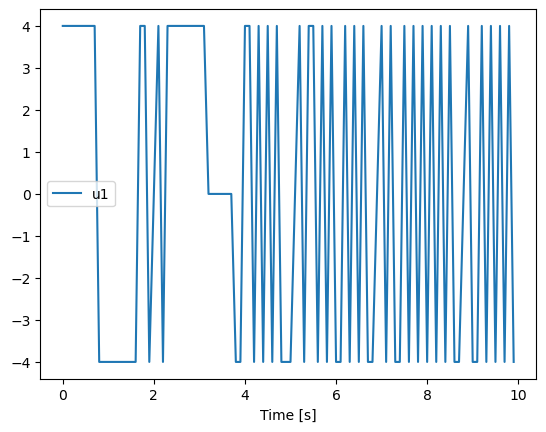

In [5]:
# we can plot the results
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, x[0,:])
plt.legend(['theta'])

plt.subplot(2,1,2)
plt.plot(t, x[1,:])
plt.legend(['omega'])

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1'])
plt.xlabel('Time [s]')

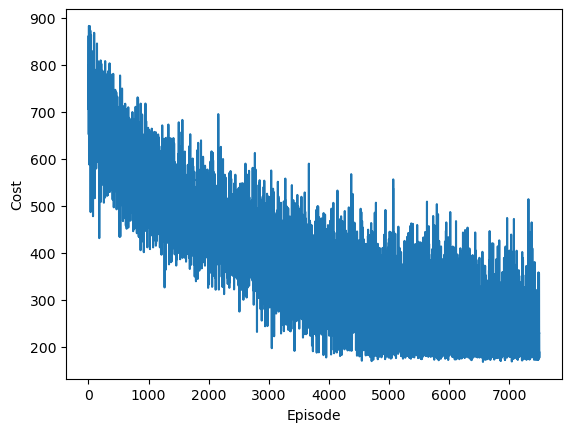

In [6]:
plt.plot(cos)
plt.xlabel('Episode')
plt.ylabel('Cost')
plt.show()

Text(0.5, 1.0, 'Policy')

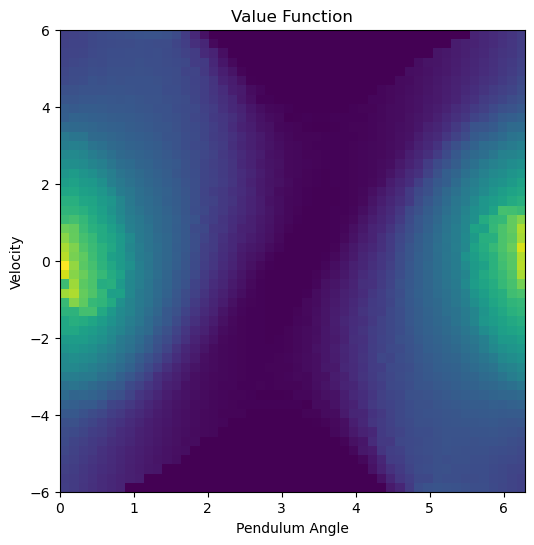

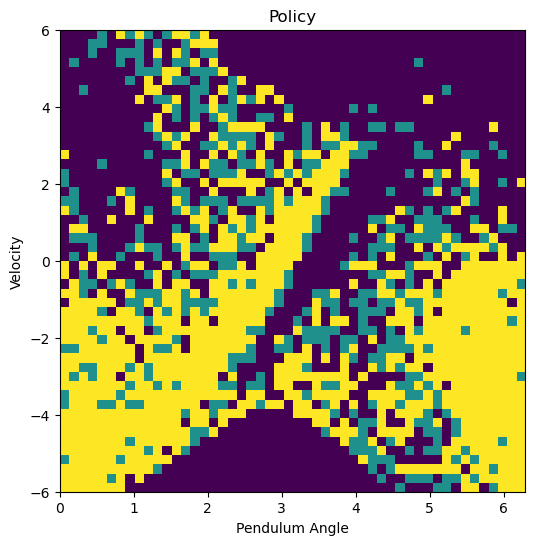

In [7]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2
vf,p=run.get_policy_and_value_function(q_table=q_table)

value_function = vf.T
policy = p.T

# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(value_function, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')